In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Union, List, Optional
from enum import Enum, auto
import os
import re
from ase.io import read
from nequip.ase import NequIPCalculator
from tqdm import tqdm
from dataclasses import dataclass
from scipy.stats import pearsonr
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class PropertyCalculator:
    '''
    Base class for property calculators. Acts as a wrapper for different calculators (VASP, NequIP, etc.)
    '''
    def __init__(self, name, has_energy=True, has_forces=True, has_stress=True):
        self.name = name
        self.has_energy = has_energy
        self.has_forces = has_forces
        self.has_stress = has_stress

    def compute_properties(self, frames):
        raise NotImplementedError("Subclasses must implement the compute_properties method.")


class VASPXMLPropertyCalculator(PropertyCalculator):
    '''
    Implementation of PropertyCalculator for VASP calculations (VASP XML files)
    '''
    def __init__(self, name, directory, base_name, has_energy=True, has_forces=True, has_stress=True):
        super().__init__(name, has_energy, has_forces, has_stress)
        self.directory = directory
        self.base_name = base_name

    def compute_properties(self, frames):            
        pattern = re.compile(f"{self.base_name}_(\\d+)\\.xml")
        vasp_files = [f for f in os.listdir(self.directory) if pattern.match(f)]
        
        def get_frame_number(filename):
            match = pattern.match(filename)
            return int(match.group(1)) if match else -1
        
        sorted_vasp_files = sorted(vasp_files, key=get_frame_number)
        
        for filename in tqdm(sorted_vasp_files, desc=f"Computing {self.name} properties"):
            vasp_atom = read(os.path.join(self.directory, filename))
            frame_number = get_frame_number(filename)
            
            if self.has_energy:
                #check for existence array and raise error if it already exists
                if f'{self.name}_total_energy' in frames.frames[frame_number].info:
                    raise ValueError(f"{self.name}_total_energy already exists in frame {frame_number}")
                frames.frames[frame_number].info[f'{self.name}_total_energy'] = vasp_atom.get_potential_energy()
            if self.has_forces:
                if f'{self.name}_forces' in frames.frames[frame_number].arrays:
                    raise ValueError(f"{self.name}_forces already exists in frame {frame_number}")
                frames.frames[frame_number].arrays[f'{self.name}_forces'] = vasp_atom.get_forces()
            if self.has_stress:
                if f'{self.name}_stress' in frames.frames[frame_number].info:
                    raise ValueError(f"{self.name}_stress already exists in frame {frame_number}")
                frames.frames[frame_number].info[f'{self.name}_stress'] = vasp_atom.get_stress()


class NequIPPropertyCalculator(PropertyCalculator):
    '''
    Implementation of PropertyCalculator for NequIP models (.pth files)
    '''
    def __init__(self, name, model_path, has_energy=True, has_forces=True, has_stress=True):
        super().__init__(name, has_energy, has_forces, has_stress)
        self.model_path = model_path

    def compute_properties(self, trajectory):
        calc = NequIPCalculator.from_deployed_model(self.model_path)
        
        for i, atom in tqdm(enumerate(trajectory.frames), total=len(trajectory.frames), desc=f"Computing {self.name} properties"):
            atom.calc = calc
            if self.has_energy:
                if f'{self.name}_total_energy' in atom.info:
                    raise ValueError(f"{self.name}_total_energy already exists in atom {i}")
                atom.info[f'{self.name}_total_energy'] = atom.get_potential_energy()
            if self.has_forces:
                if f'{self.name}_forces' in atom.arrays:
                    raise ValueError(f"{self.name}_forces already exists in atom {i}")
                atom.arrays[f'{self.name}_forces'] = atom.get_forces()
            if self.has_stress:
                if f'{self.name}_stress' in atom.info:
                    raise ValueError(f"{self.name}_stress already exists in atom {i}")
                atom.info[f'{self.name}_stress'] = atom.get_stress()

class Property(Enum):
    """Enum for different types of properties with their corresponding units."""
    ENERGY = ('energy', 'eV')
    FORCES = ('forces', 'eV/Å')
    STRESS = ('stress', 'eV/Å³')

    def __init__(self, key: str, unit: str):
        self.key = key
        self.unit = unit

    def get_units(self):
        return self.unit

    def get_name(self):
        return self.key

class Frames:
    def __init__(self, xyz_file):
        self.xyz_file = xyz_file
        self.frames = read(self.xyz_file, index=':')

    def __len__(self):
        return len(self.frames)
    
    def get_number_of_atoms(self):
        return len(self.frames[0])
    
    def get_atom_types_and_indices(self) -> dict[str: List[int]]:
        """
        Get the atom types and their corresponding indices.

        Returns:
            dict{'str': List[int]}: Dictionary with atom types as keys and their indices as values.
        """
        atom_types = defaultdict(list)
        for i, atom in enumerate(self.frames[0]):
            atom_types[atom.symbol].append(i)
        return atom_types

    def add_method_data(self, method):
        method.compute_properties(self)

    def get_property(self, property: Property, 
                     calculator: 'PropertyCalculator', 
                     frame_number: Union[int, slice] = slice(None)) -> Union[np.ndarray, List[np.ndarray]]:
        """
        Get a specific property for given frame(s) and calculator.

        Args:
            property (Property): The type of property to retrieve.
            calculator (PropertyCalculator): The calculator used to compute the property.
            frame_number (Union[int, slice], optional): The frame number(s) to get the property for. Defaults to all frames.

        Returns:
            Union[np.ndarray, List[np.ndarray]]: 
            - For ENERGY: 1D array of shape (n_frames,)
            - For FORCES: 3D array of shape (n_frames, n_atoms, 3) if slice, or 2D array of shape (n_atoms, 3) if int
            - For STRESS: 2D array of shape (n_frames, 6) if slice, or 1D array of shape (6,) if int

        Raises:
            ValueError: If an invalid property type is provided or frame number is out of bounds.
        """
        property_map = {
            Property.ENERGY: lambda frame: frame.info[f'{calculator.name}_total_energy'],
            Property.FORCES: lambda frame: frame.arrays[f'{calculator.name}_forces'],
            Property.STRESS: lambda frame: frame.info[f'{calculator.name}_stress']
        }
        if property not in property_map:
            raise ValueError("Invalid property type")

        get_frame_property = property_map[property]

        self._check_frame_bounds(frame_number)

        if isinstance(frame_number, int):
            return np.array(get_frame_property(self.frames[frame_number]))
        else:
            return np.array([get_frame_property(frame) for frame in self.frames[frame_number]])

    @staticmethod
    def calculate_von_mises_stress(stress_tensor):
        """
        Calculate the von Mises stress from a stress tensor.

        Args:
            stress_tensor (np.ndarray): Stress tensor in Voigt notation [xx, yy, zz, yz, xz, xy].

        Returns:
            np.ndarray: von Mises stress, shape matches input except last dimension is reduced to 1.
        """
        xx, yy, zz, yz, xz, xy = stress_tensor.T
        von_mises = np.sqrt(0.5 * ((xx - yy)**2 + (yy - zz)**2 + (zz - xx)**2 + 6*(yz**2 + xz**2 + xy**2)))
        return  np.array(von_mises).reshape(-1)

    def _check_frame_bounds(self, frame_number: Union[int, slice]):
        """
        Check if the given frame number or slice is within bounds.

        Args:
            frame_number (Union[int, slice]): The frame number(s) to check.

        Raises:
            ValueError: If the frame number is out of bounds.
        """

        if isinstance(frame_number, int):
            if frame_number < 0 or frame_number >= len(self.frames):
                raise ValueError(f"Invalid frame number {frame_number}")
        elif isinstance(frame_number, slice):
            if frame_number.start is not None and frame_number.start < 0:
                raise ValueError(f"Invalid start frame number {frame_number.start}")
            if frame_number.stop is not None and frame_number.stop > len(self.frames):
                raise ValueError(f"Invalid stop frame number {frame_number.stop}")
        else:
            raise ValueError("Invalid frame number")

    def get_property_magnitude(self, property: Property,
                            calculator: 'PropertyCalculator',
                            frame_number: Union[int, slice] = slice(None)) -> np.ndarray:
        data = self.get_property(property, calculator, frame_number)
        
        """
        Get the magnitude of a property for given frame(s) and calculator.

        Args:
            property (PropertyType): The type of property to retrieve.
            calculator (PropertyCalculator): The calculator used to compute the property.
            frame_number (Union[int, slice], optional): The frame number(s) to get the property for. Defaults to all frames.

        Returns:
            np.ndarray: 
            - For ENERGY: 1D array of shape (n_frames,)
            - For FORCES: 2D array of shape (n_frames, n_atoms) 
            - For STRESS: 1D array of shape (n_frames,)
        """

        if property == Property.ENERGY:
            return np.array(data).reshape(-1)
        elif property == Property.FORCES:
            # For each frame, calculate the magnitude of the force for each atom
            if isinstance(frame_number, int):
                return np.linalg.norm(data, axis=-1).reshape(1, -1)
            else:
                return np.linalg.norm(data, axis=-1)
        elif property == Property.STRESS:
            return self.calculate_von_mises_stress(data)
        else:
            raise ValueError("Invalid property type")

    def get_mae(self, property: Property, 
                reference_calculator: 'PropertyCalculator', 
                target_calculator: Union['PropertyCalculator', List['PropertyCalculator']],
                frame_number: Optional[Union[int, slice]] = slice(None)) -> Union[np.ndarray, List[np.ndarray], float , List[float]]:
        """
        Calculate Mean Absolute Error (MAE) across all specified frames.

        Args:
            property (PropertyType): The type of property to calculate MAE for.
            reference_calculator (PropertyCalculator): The reference calculator.
            target_calculator (Union[PropertyCalculator, List[PropertyCalculator]]): The target calculator(s).
            frame_number (Optional[Union[int, slice]], optional): The frame number(s) to calculate MAE for. Defaults to all frames.

        Returns:
            Union[float, List[np.ndarray], List[float]]: 
            - For ENERGY: float, List[float]
            - For FORCES: ndarray (n_frames, n_atoms), List[ndarray (n_atoms,)]
            - For STRESS: float, List[float]
        """
        reference_data = self.get_property_magnitude(property, reference_calculator, frame_number)
        
        if not isinstance(target_calculator, list):
            target_calculators = [target_calculator]
        else:
            target_calculators = target_calculator
        
        maes = []
        for calc in target_calculators:
            target_data = self.get_property_magnitude(property, calc, frame_number)
            if property == Property.ENERGY:
                mae = np.mean(np.abs(reference_data - target_data))
            elif property == Property.FORCES:
                mae = np.mean(np.abs(reference_data - target_data), axis=0)
            elif property == Property.STRESS:
                mae = np.mean(np.abs(reference_data - target_data))
            maes.append(mae)
        
        return maes[0] if len(maes) == 1 else maes

    def get_rmse(self, property: Property, 
                reference_calculator: 'PropertyCalculator', 
                target_calculator: Union['PropertyCalculator', List['PropertyCalculator']],
                frame_number: Optional[Union[int, slice]] = slice(None)) -> Union[float, List[np.ndarray], List[float]]:
        """
        Calculate Root Mean Square Error (RMSE) across all specified frames.

        Args:
            property (PropertyType): The type of property to calculate RMSE for.
            reference_calculator (PropertyCalculator): The reference calculator.
            target_calculator (Union[PropertyCalculator, List[PropertyCalculator]]): The target calculator(s).
            frame_number (Optional[Union[int, slice]], optional): The frame number(s) to calculate RMSE for. Defaults to all frames.

        Returns:
            Union[float, List[np.ndarray], List[float]]: 
            - For ENERGY: float, List[float]
            - For FORCES: ndarray (n_atoms,), List[ndarray (n_atoms,)]
            - For STRESS: float, List[float]
        """
        reference_data = self.get_property_magnitude(property, reference_calculator, frame_number)
        
        if not isinstance(target_calculator, list):
            target_calculators = [target_calculator]
        else:
            target_calculators = target_calculator
        
        rmses = []
        for calc in target_calculators:
            target_data = self.get_property_magnitude(property, calc, frame_number)
            if property == Property.ENERGY:
                rmse = np.sqrt(np.mean((reference_data - target_data) ** 2))
            elif property == Property.FORCES:
                rmse = np.sqrt(np.mean((reference_data - target_data) ** 2, axis=0))  # Mean over frames, keeping per-atom dimension
            elif property == Property.STRESS:
                rmse = np.sqrt(np.mean((reference_data - target_data) ** 2))
            rmses.append(rmse)
        
        return rmses[0] if len(rmses) == 1 else rmses
    
    def get_correlation(self, property: Property, 
                        reference_calculator: 'PropertyCalculator', 
                        target_calculator: Union['PropertyCalculator', List['PropertyCalculator']],
                        frame_number: Optional[Union[int, slice]] = slice(None)) -> Union[float, List[np.ndarray], List[float]]:
        """
        Calculate Pearson correlation coefficient across all specified frames.

        Args:
            property (PropertyType): The type of property to calculate correlation for.
            reference_calculator (PropertyCalculator): The reference calculator.
            target_calculator (Union[PropertyCalculator, List[PropertyCalculator]]): The target calculator(s).
            frame_number (Optional[Union[int, slice]], optional): The frame number(s) to calculate correlation for. Defaults to all frames.

        Returns:
            Union[float, List[np.ndarray], List[float]]: 
            - For ENERGY: float, List[float]
            - For FORCES: ndarray (n_atoms,), List[ndarray (n_atoms,)]
            - For STRESS: float, List[float]
        """
        reference_data = self.get_property_magnitude(property, reference_calculator, frame_number)
        
        if not isinstance(target_calculator, list):
            target_calculators = [target_calculator]
        else:
            target_calculators = target_calculator
        
        correlations = []
        for calc in target_calculators:
            target_data = self.get_property_magnitude(property, calc, frame_number)
            if property == Property.ENERGY:
                if reference_data.size < 2 or target_data.size < 2:
                    correlation = np.nan  # Not enough data points to compute correlation
                else:
                    correlation = pearsonr(reference_data, target_data)[0]
            elif property == Property.FORCES:
                if reference_data.shape[0] < 2:
                    correlation = np.full(reference_data.shape[1], np.nan)  # Not enough frames to compute correlation per atom
                else:
                    # Calculate correlation for each atom across frames
                    correlation = np.array([pearsonr(reference_data[:, atom], target_data[:, atom])[0] for atom in range(reference_data.shape[1])])
            elif property == Property.STRESS:
                if reference_data.size < 2 or target_data.size < 2:
                    correlation = np.nan  # Not enough data points to compute correlation
                else:
                    correlation = pearsonr(reference_data, target_data)[0]
            correlations.append(correlation)
        
        return correlations[0] if len(correlations) == 1 else correlations
    

class BasePlotter:
    PROPERTY = None 

    @classmethod
    def _create_scatter_plot(cls, ax, reference_data: np.ndarray, target_data: np.ndarray, 
                             reference_calculator: PropertyCalculator, target_calculator: PropertyCalculator) -> plt.Axes:
        ax.scatter(reference_data.flatten(), target_data.flatten(), alpha=0.6, color='black', s=20, edgecolors='none')

        all_data = np.concatenate([reference_data.flatten(), target_data.flatten()])
        min_val, max_val = np.min(all_data), np.max(all_data)
        range_val = max_val - min_val
        buffer = range_val * 0.05
        plot_min, plot_max = min_val - buffer, max_val + buffer

        ax.plot([plot_min, plot_max], [plot_min, plot_max], 'k--', linewidth=1)
        ax.set_xlabel(f'{reference_calculator.name} ({cls.PROPERTY.get_units()})', fontsize=10)
        ax.set_ylabel(f'{target_calculator.name} ({cls.PROPERTY.get_units()})', fontsize=10)
        
        ax.set_title(f'{cls.PROPERTY.get_name().capitalize()} Comparison', fontsize=12)

        ax.grid(True, linestyle=':', alpha=0.7)
        ax.set_xlim(plot_min, plot_max)
        ax.set_ylim(plot_min, plot_max)
        ax.set_aspect('equal', adjustable='box')

        return ax

    @classmethod
    def _add_metrics_to_plot(cls, ax, frames, reference_calculator, target_calculator, frame_number):
        mae = frames.get_mae(cls.PROPERTY, reference_calculator, target_calculator, frame_number)
        rmse = frames.get_rmse(cls.PROPERTY, reference_calculator, target_calculator, frame_number)
        correlation = frames.get_correlation(cls.PROPERTY, reference_calculator, target_calculator, frame_number)
        
        stats_text = cls.format_metrics(mae, rmse, correlation)
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.8))

    @classmethod
    def plot_scatter(cls, frames: Frames, reference_calculator: PropertyCalculator, 
                     target_calculator: PropertyCalculator, frame_number: Union[int, slice] = slice(None),
                     title: str = None, display_metrics: bool = True):
        if cls.PROPERTY is None:
            raise NotImplementedError("Subclasses must define PROPERTY")

        reference_data = frames.get_property_magnitude(cls.PROPERTY, reference_calculator, frame_number)
        target_data = frames.get_property_magnitude(cls.PROPERTY, target_calculator, frame_number)

        fig, ax = plt.subplots(figsize=(6, 5))
        ax = cls._create_scatter_plot(ax, reference_data, target_data, reference_calculator, target_calculator)
        
        if display_metrics:
            cls._add_metrics_to_plot(ax, frames, reference_calculator, target_calculator, frame_number)

        if title:
            ax.set_title(title, fontsize=12)

        plt.tight_layout()
        plt.show()

    @classmethod
    def plot_all_scatter(cls, frames: Frames, reference_calculator: PropertyCalculator,
                         target_calculator: PropertyCalculator, frame_number: Union[int, slice] = slice(None),
                         display_metrics: bool = True):
        properties = [Property.ENERGY, Property.FORCES, Property.STRESS]
        plotters = [EnergyPlotter, ForcesPlotter, StressPlotter]
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for ax, property, plotter in zip(axes, properties, plotters):
            reference_data = frames.get_property_magnitude(property, reference_calculator, frame_number)
            target_data = frames.get_property_magnitude(property, target_calculator, frame_number)
            
            plotter._create_scatter_plot(ax, reference_data, target_data, reference_calculator, target_calculator)
            if display_metrics:
                plotter._add_metrics_to_plot(ax, frames, reference_calculator, target_calculator, frame_number)
        
        plt.tight_layout()
        plt.show()




    @classmethod
    def plot_box(cls, frames: Frames, reference_calculator: PropertyCalculator, 
                 target_calculators: Union[PropertyCalculator, List[PropertyCalculator]], 
                 frame_number: Union[int, slice] = slice(None),
                 per_atom: bool = False):
        if cls.PROPERTY is None:
            raise NotImplementedError("Subclasses must define PROPERTY")

        if not isinstance(target_calculators, list):
            target_calculators = [target_calculators]
        fig_width = 3 + (len(target_calculators) * 2)
        fig, ax = plt.subplots(figsize=(fig_width, 6))
        
        data = []
        labels = []

        reference_data = frames.get_property_magnitude(cls.PROPERTY, reference_calculator, frame_number)
        num_atoms = frames.get_number_of_atoms()

        for target_calc in target_calculators:
            target_data = frames.get_property_magnitude(cls.PROPERTY, target_calc, frame_number)
            
            error = np.abs(reference_data - target_data)
            
            if error.ndim == 2:  # Multiple frames
                if not per_atom:
                    error = np.mean(error, axis=0)  # Average over frames if not per_atom
                else:
                    error = error.flatten()  # Keep all frame data if per_atom
            elif error.ndim > 2:
                raise ValueError(f"Unexpected number of dimensions in error: {error.ndim}")
            
            if per_atom:
                error = error / num_atoms
            
            data.append(error)
            labels.append(target_calc.name)

        ax.boxplot(data, labels=labels)

        ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

        ax.set_axisbelow(True)

        title_suffix = "per atom" if per_atom else "per structure"
        ax.set_title(f'{cls.PROPERTY.get_name().capitalize()} Error Distribution ({title_suffix})')
        ax.set_ylabel(f'{cls.PROPERTY.get_name().capitalize()} Error ({cls.PROPERTY.get_units()})')

        plt.tight_layout()
        plt.show()

    @classmethod
    def format_metrics(cls, mae, rmse, correlation, add_whitespace=""):
        raise NotImplementedError("Subclasses must implement format_metrics method")

    @classmethod
    def print_metrics(cls, frames, reference_calculator, target_calculators, frame_number: Union[int, slice] = slice(None)):
        raise NotImplementedError("Subclasses must implement print_metrics method")

class EnergyPlotter(BasePlotter):
    PROPERTY = Property.ENERGY

    @classmethod
    def format_metrics(cls, mae, rmse, correlation, add_whitespace=""):
        return (f"{add_whitespace}MAE: {mae:.6f} {cls.PROPERTY.get_units()}\n"
                f"{add_whitespace}RMSE: {rmse:.6f} {cls.PROPERTY.get_units()}\n"
                f"{add_whitespace}Correlation: {correlation:.6f}")

    @classmethod
    def print_metrics(cls, frames, reference_calculator, target_calculators, frame_number: Union[int, slice] = slice(None)):
        print(f"\nEnergy Metrics (vs {reference_calculator.name}):")
        print("---------------")
        for target_calc in (target_calculators if isinstance(target_calculators, list) else [target_calculators]):
            mae = frames.get_mae(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            rmse = frames.get_rmse(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            correlation = frames.get_correlation(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            
            num_atoms = frames.get_number_of_atoms()
        
            print(f"\n  {target_calc.name}:")
            print(cls.format_metrics(mae, rmse, correlation, "    "))
            print(f"    MAE (average per atom): {mae/num_atoms:.6f} {cls.PROPERTY.get_units()}")
            print(f"    RMSE (average per atom): {rmse/num_atoms:.6f} {cls.PROPERTY.get_units()}")


class StressPlotter(BasePlotter):
    PROPERTY = Property.STRESS

    @classmethod
    def format_metrics(cls, mae, rmse, correlation, add_whitespace=""):
        return (f"{add_whitespace}MAE: {mae:.6f} {cls.PROPERTY.get_units()}\n"
                f"{add_whitespace}RMSE: {rmse:.6f} {cls.PROPERTY.get_units()}\n"
                f"{add_whitespace}Correlation: {correlation:.6f}")

    @classmethod
    def print_metrics(cls, frames, reference_calculator, target_calculators, frame_number: Union[int, slice] = slice(None)):
        print(f"\nStress Metrics (vs {reference_calculator.name}):")
        print("----------------")
        for target_calc in (target_calculators if isinstance(target_calculators, list) else [target_calculators]):
            mae = frames.get_mae(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            rmse = frames.get_rmse(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            correlation = frames.get_correlation(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            
            print(f"\n  {target_calc.name}:")
            print(cls.format_metrics(mae, rmse, correlation, "    "))
            print("    (All values per structure)")


class ForcesPlotter(BasePlotter):
    PROPERTY = Property.FORCES

    @classmethod
    def format_metrics(cls, mae, rmse, correlation, add_whitespace=""):
        return (f"{add_whitespace}MAE: {np.mean(mae):.6f} {cls.PROPERTY.get_units()}\n"
                f"{add_whitespace}RMSE: {np.mean(rmse):.6f} {cls.PROPERTY.get_units()}\n"
                f"{add_whitespace}Correlation: {np.mean(correlation):.6f}")

    @classmethod
    def print_metrics(cls, frames, reference_calculator, target_calculators, frame_number: Union[int, slice] = slice(None)):
        print(f"\nForces Metrics (vs {reference_calculator.name}):")
        print("----------------")
        for target_calc in (target_calculators if isinstance(target_calculators, list) else [target_calculators]):
            mae = frames.get_mae(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            rmse = frames.get_rmse(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            correlation = frames.get_correlation(cls.PROPERTY, reference_calculator, target_calc, frame_number)
            number_of_atoms = frames.get_number_of_atoms()
            
            print(f"\n  {target_calc.name}:")
            print("    Total:")
            print(cls.format_metrics(mae, rmse, correlation, "      "))
            print(f'      MAE (average per atom): {np.mean(mae) / number_of_atoms:.6f} {cls.PROPERTY.get_units()}')
            print(f'      RMSE (average per atom): {np.mean(rmse) / number_of_atoms:.6f} {cls.PROPERTY.get_units()}')
            
            print('\n    Per Atom Type:')
            atoms_dict = frames.get_atom_types_and_indices()
            for atom_type, indices in atoms_dict.items():
                mae_per_atom = mae[..., indices]
                rmse_per_atom = rmse[..., indices]
                correlation_per_atom = correlation[..., indices]
                print(f"      {atom_type}:")
                print(cls.format_metrics(mae_per_atom, rmse_per_atom, correlation_per_atom, "        "))

    @classmethod
    def plot_box(cls, frames: Frames, reference_calculator: PropertyCalculator,
                 target_calculators: Union[PropertyCalculator, List[PropertyCalculator]],
                 frame_number: Union[int, slice] = slice(None),
                 per_atom: bool = False):
        if not isinstance(target_calculators, list):
            target_calculators = [target_calculators]

        data = []
        labels = []
        atom_types = frames.get_atom_types_and_indices()
        
        if per_atom:
            fig_width = 3 + (len(target_calculators) * len(atom_types) * 2)
        else:
            fig_width = 3 + (len(target_calculators) * 2)
        
        fig, ax = plt.subplots(figsize=(fig_width, 6))

        reference_forces = frames.get_property_magnitude(cls.PROPERTY, reference_calculator, frame_number)

        if per_atom:
            for atom_type, indices in atom_types.items():
                for target_calc in target_calculators:
                    target_forces = frames.get_property_magnitude(cls.PROPERTY, target_calc, frame_number)
                    error = np.abs(reference_forces[..., indices] - target_forces[..., indices])
                    if error.ndim == 2:
                        error = error.flatten()
                    data.append(error)
                    labels.append(f"{atom_type} ({target_calc.name})")
        else:
            for target_calc in target_calculators:
                target_forces = frames.get_property_magnitude(cls.PROPERTY, target_calc, frame_number)
                error = np.abs(reference_forces - target_forces)
                if error.ndim == 2:
                    error = error.flatten()
                data.append(error)
                labels.append(target_calc.name)

        ax.boxplot(data, labels=labels)
        
        # Add this line after your boxplot call
        ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

        # Also, ensure the grid is behind the plot elements
        ax.set_axisbelow(True)

        if per_atom:
            title = 'Forces Error Distribution (per atom type)'
        else:
            title = 'Total Forces Error Distribution'
        
        ax.set_title(title)
        ax.set_ylabel(f'Force Error ({cls.PROPERTY.get_units()})')

        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Load Frames - can be any ASE supported format
frames = Frames('examples/example_frames.extxyz')

# Set up calculators
vasp_calc = VASPXMLPropertyCalculator('DFT (PBE)', 'examples/31_vaspout_xml_frames', 'vasprun_frame')
nequip_calc = NequIPPropertyCalculator('Allegro', 'examples/nequip_model.pth')

# Add data from calculators
frames.add_method_data(vasp_calc)
frames.add_method_data(nequip_calc)


Computing DFT (PBE) properties: 100%|██████████| 31/31 [00:00<00:00, 55.16it/s]
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/nequip/utils/_global_options.py:59: UserWarning: !! Upstream issues in PyTorch versions >1.11 have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. At present we *strongly* recommend the use of PyTorch 1.11 if using CUDA devices; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/nequip/utils/_global_options.py:70: UserWarning: Setting the GLOBAL value for jit fusion strategy to `[('DYNAMIC', 3)]` which is different than the previous value of `[('STATIC', 2), ('DYNAMIC', 10)]`
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11

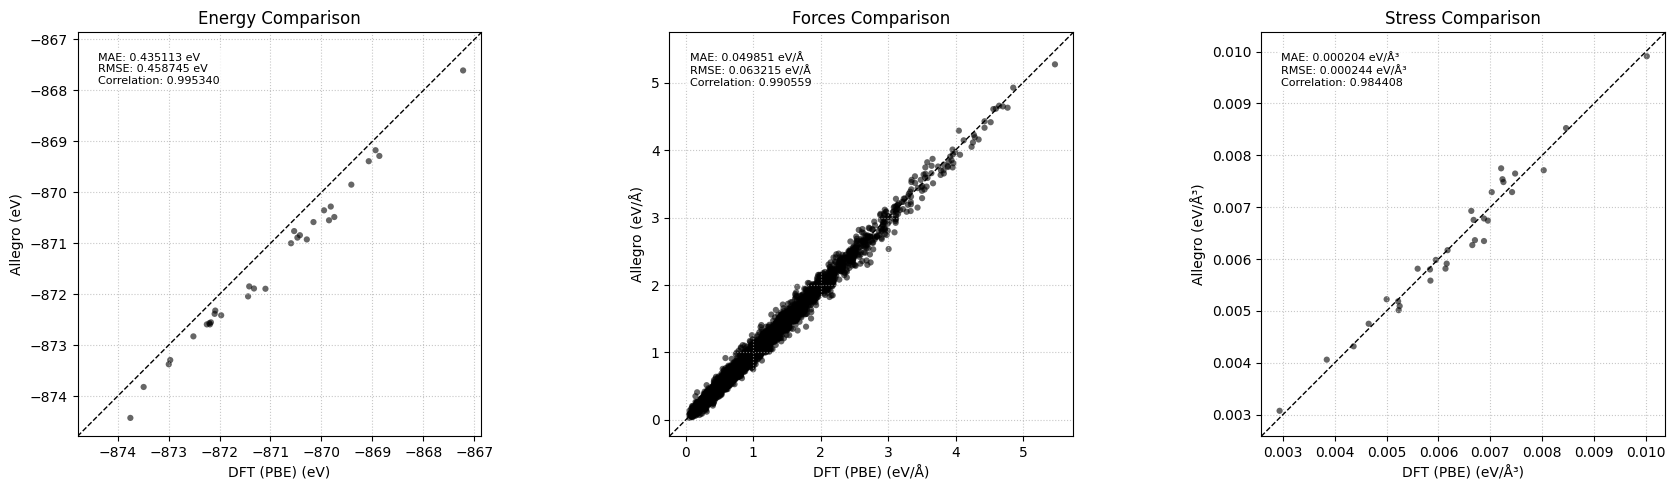

In [4]:
BasePlotter.plot_all_scatter(frames, vasp_calc, nequip_calc)